In [1]:
import disentangler as dt
from disentangler.dependencies import *
import scvi

import torch
assert torch.cuda.is_available()

atac_data = dt.bonemarrow.utils.load_ATAC_data()

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


## Categorical only

In [2]:
model = mira.topics.TopicModel(
    *atac_data.shape,
    feature_type='accessibility',
    latent_space='dirichlet',
    categorical_covariates = ['Site', 'DonorNumber'],
    min_learning_rate = 0.001,
    max_learning_rate = 0.1,
    counts_layer='counts',
)

In [3]:
tuner = mira.topics.SpeedyTuner(
    model = model,
    min_topics=10,
    max_topics=30,
    n_jobs=1,
    save_name = 'bonemarrow/atac/final/cat/0',
)

tuner.purge()

In [4]:
print(tuner)

Trials finished: 25 | Best trial: 0 | Best score: 1.2106e+04
Press ctrl+C,ctrl+C or esc,I+I,I+I in Jupyter notebook to stop early.

Tensorboard logidr: runs/bonemarrow/atac/final/cat/0
#Topics | #Trials 

     11 | ■ 
     14 | ■ 
     15 | ■ ■ 
     16 | ■ 
     17 | ■ 
     19 | ■ ■ 
     20 | ■ 
     21 | ■ 
     24 | ■ ■ 
     25 | ■ ■ ■ ■ ■ ■ 
     26 | ■ ■ ■ ■ 
     27 | ■ 
     29 | ■ ■ 

Trial | Result (● = best so far)         | Params
 #0   | ● | completed, score: 1.2106e+04 | {'decoder_dropout': 0.0777, 'num_topics': 25}
 #1   |   | pruned at step: 8            | {'decoder_dropout': 0.0599, 'num_topics': 29}
 #2   |   | completed, score: 1.2109e+04 | {'decoder_dropout': 0.0695, 'num_topics': 25}
 #3   |   | pruned at step: 8            | {'decoder_dropout': 0.1734, 'num_topics': 19}
 #4   |   | pruned at step: 8            | {'decoder_dropout': 0.1070, 'num_topics': 16}
 #5   |   | pruned at step: 8            | {'decoder_dropout': 0.1722, 'num_topics': 11}
 #6   |   | compl

In [9]:
train_atac, test_atac = model.train_test_split(atac_data)
del test_atac

In [5]:
model = tuner.fetch_best_weights()

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [10]:
model.fit(train_atac)

Gathering dataset statistics:   0%|          | 0/53730 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/24 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Moving model to device: cpu


dirichlet_accessibility_covariate-model(
  (decoder): Decoder(
    (beta): Linear(in_features=25, out_features=116490, bias=False)
    (bn): BatchNorm1d(116490, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.05, inplace=False)
    (drop2): Dropout(p=0.07773771510634347, inplace=False)
    (batch_effect_model): Sequential(
      (0): ConcatLayer()
      (1): Sequential(
        (0): Linear(in_features=39, out_features=32, bias=False)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.05, inplace=False)
      )
      (2): Linear(in_features=32, out_features=116490, bias=True)
      (3): BatchNorm1d(116490, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
  )
  (encoder): DANSkipEncoder(
    (embedding): Embedding(116491, 256, padding_idx=0)
    (embedding_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [11]:
model.predict(atac_data)
model.get_umap_features(atac_data, box_cox=0.1)

Predicting latent vars:   0%|          | 0/263 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


<AxesSubplot:xlabel='X_umap1', ylabel='X_umap2'>

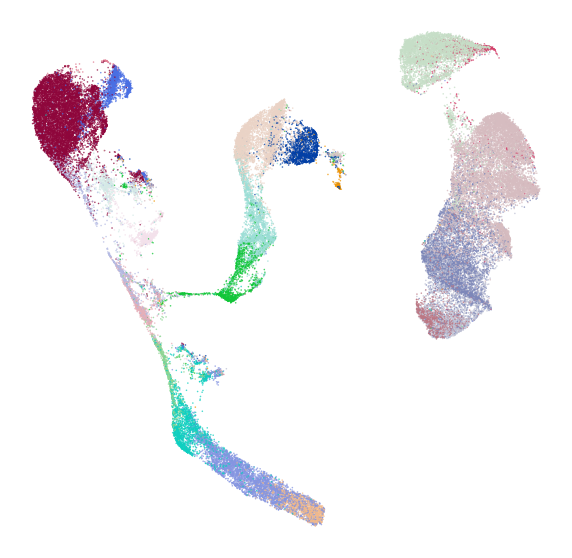

In [12]:
sc.pp.neighbors(atac_data, use_rep="X_umap_features", metric = 'manhattan')
sc.tl.umap(atac_data, min_dist=0.1, negative_sample_rate=3)

fig, ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.embedding(atac_data, color = 'cell_type', ax = ax, frameon=False, s = 10,
          legend_loc='none', title = '', show = False, alpha = 0.75, basis = 'X_umap')

In [14]:
model.save('data/bonemarrow/models/mira_atac_nofrip.pth')

## Main model training

In [2]:
model = mira.topics.TopicModel(
    *atac_data.shape,
    feature_type='accessibility',
    latent_space='dirichlet',
    categorical_covariates = ['Site', 'DonorNumber'],
    continuous_covariates = ['ATAC_reads_in_peaks_frac'],
    min_learning_rate = 0.001,
    max_learning_rate = 0.1,
    counts_layer='counts',
)

!rm -rf data/bonemarrow/atac_train_dataset/ data/bonemarrow/atac_test_dataset/

train, test = mira.topics.SpeedyTuner.train_test_split(atac_data,
                                                       train_size=0.8, 
                                                       stratify=atac_data.obs_vector('batch'),
                                                       seed = 0)
model.write_ondisk_dataset(train, dirname='data/bonemarrow/atac_train_dataset/')
model.write_ondisk_dataset(test, dirname='data/bonemarrow/atac_test_dataset/')
del train, test

Writing dataset to disk:   0%|          | 0/53 [00:00<?, ?it/s]

Writing dataset to disk:   0%|          | 0/14 [00:00<?, ?it/s]

In [18]:
tuner = mira.topics.SpeedyTuner(
    model = model,
    min_topics=10,
    max_topics=30,
    n_jobs=1,
    save_name = 'bonemarrow/atac/final/0',
)

tuner.purge()

/liulab/alynch/projects/mira-multiome-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:11: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  # This is added back by InteractiveShellApp.init_path()


In [19]:
tuner.fit(
    'data/bonemarrow/atac_train_dataset/',
    'data/bonemarrow/atac_test_dataset/'
)

ERROR:mira.topic_model.trainer:Optimal # of topics was very close to the maximum topics boundary! Please increase "max_topics" and re-tune.


Trials finished: 35 | Best trial: 6 | Best score: 1.2064e+04
Press ctrl+C,ctrl+C or esc,I+I,I+I in Jupyter notebook to stop early.

Tensorboard logidr: runs/bonemarrow/atac/final/0
#Topics | #Trials 

     10 | ■ ■ 
     11 | ■ 
     14 | ■ 
     16 | ■ ■ 
     21 | ■ ■ 
     22 | ■ ■ 
     24 | ■ 
     25 | ■ ■ 
     26 | ■ ■ ■ 
     27 | ■ ■ ■ ■ ■ ■ ■ 
     28 | ■ ■ ■ ■ ■ ■ 
     29 | ■ ■ ■ 
     30 | ■ ■ 

Trial | Result (● = best so far)         | Params
 #0   | ● | completed, score: 1.2067e+04 | {'decoder_dropout': 0.0819, 'num_topics': 30}
 #1   |   | pruned at step: 8            | {'decoder_dropout': 0.1628, 'num_topics': 28}
 #2   |   | pruned at step: 8            | {'decoder_dropout': 0.1157, 'num_topics': 11}
 #3   |   | pruned at step: 16           | {'decoder_dropout': 0.1458, 'num_topics': 30}
 #4   |   | pruned at step: 8            | {'decoder_dropout': 0.0534, 'num_topics': 10}
 #5   |   | completed, score: 1.2067e+04 | {'decoder_dropout': 0.1226, 'num_topics': 28}
 #6

dirichlet_accessibility_covariate-model(
  (decoder): Decoder(
    (beta): Linear(in_features=29, out_features=116490, bias=False)
    (bn): BatchNorm1d(116490, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.05, inplace=False)
    (drop2): Dropout(p=0.07927895008784627, inplace=False)
    (batch_effect_model): Sequential(
      (0): ConcatLayer()
      (1): Sequential(
        (0): Linear(in_features=44, out_features=32, bias=False)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.05, inplace=False)
      )
      (2): Linear(in_features=32, out_features=116490, bias=True)
      (3): BatchNorm1d(116490, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
  )
  (encoder): DANSkipEncoder(
    (embedding): Embedding(116491, 256, padding_idx=0)
    (embedding_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

<AxesSubplot:xlabel='Num_topics', ylabel='Elbo'>

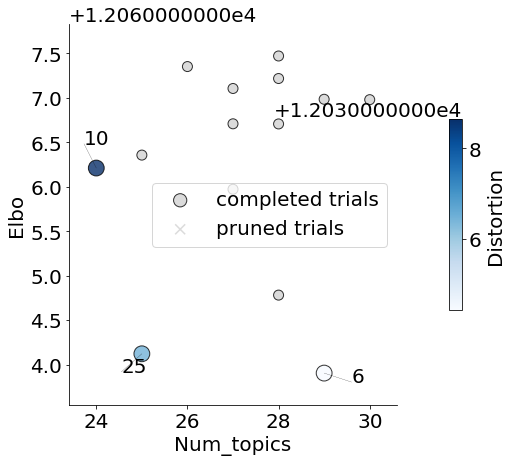

In [23]:
tuner.plot_pareto_front()

In [34]:
model = tuner.fetch_weights(25)

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [35]:
model.predict(atac_data)
model.get_umap_features(atac_data, box_cox=0.1)

Predicting latent vars:   0%|          | 0/263 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


<AxesSubplot:xlabel='X_umap1', ylabel='X_umap2'>

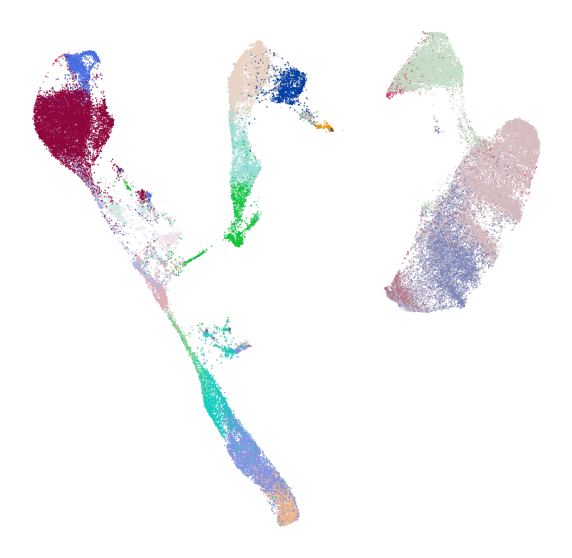

In [36]:
sc.pp.neighbors(atac_data, use_rep="X_umap_features", metric = 'manhattan')
sc.tl.umap(atac_data, min_dist=0.1, negative_sample_rate=3)

fig, ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.embedding(atac_data, color = 'cell_type', ax = ax, frameon=False, s = 10,
          legend_loc='none', title = '', show = False, alpha = 0.75, basis = 'X_umap')

In [37]:
from sklearn.metrics import silhouette_samples

In [38]:
model.get_umap_features(atac_data, box_cox=0.5)
silhouette_samples(atac_data.obsm['X_umap_features'], atac_data.obs_vector('cell_type')).mean()

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


0.16596693692029432

In [39]:
model.save(dt.bonemarrow.config.MIRA_ATAC)

## MIRA ATAC no batch

In [25]:
nobatch_model = mira.topics.TopicModel(
    *atac_data.shape,
    feature_type='accessibility',
    latent_space='dirichlet',
    #categorical_covariates = ['Site', 'DonorNumber'],
    #continuous_covariates = ['ATAC_reads_in_peaks_frac'],
    min_learning_rate = 0.001,
    max_learning_rate = 0.1,
    num_topics = 31,
    seed = 2569,
    counts_layer='counts',
    decoder_dropout = 0.05836452426925704
)

In [15]:
nobatch_model.write_ondisk_dataset(atac_data, dirname='data/bonemarrow/nobatch_atac_train_dataset/')

Writing dataset to disk:   0%|          | 0/66 [00:00<?, ?it/s]

In [26]:
nobatch_model.fit('data/bonemarrow/nobatch_atac_train_dataset/')

Epoch 0:   0%|          | 0/24 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Moving model to device: cpu


dirichlet_accessibility_model(
  (decoder): Decoder(
    (beta): Linear(in_features=31, out_features=116490, bias=False)
    (bn): BatchNorm1d(116490, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.05, inplace=False)
    (drop2): Dropout(p=0.05836452426925704, inplace=False)
  )
  (encoder): DANSkipEncoder(
    (embedding): Embedding(116491, 256, padding_idx=0)
    (embedding_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (output_layer): Sequential(
      (0): Linear(in_features=256, out_features=62, bias=False)
      (1): BatchNorm1d(62, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (hidden_layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=257, out_features=256, bias=False)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.01, inplace=False)
      )
    )
  )
)

In [27]:
nobatch_model.save(dt.bonemarrow.config.MIRA_ATAC_NO_CORRECTION)

## Train PeakVI

In [35]:
scvi.model.PEAKVI.setup_anndata(
    atac_data,
    layer="counts",
    categorical_covariate_keys=["Site", "DonorNumber"],
)

In [36]:
model = scvi.model.PEAKVI(atac_data)

In [37]:
n_epochs_scVI = np.min([round((20000 / atac_data.n_obs) * 400), 400])
n_epochs_scVI

119

In [40]:
import tqdm
tqdm.tqdm()


0it [00:00, ?it/s]

In [41]:
model.train(max_epochs=119)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/liulab/alynch/projects/mira-multiome-analysis/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:386: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  f"The `Callback.{hook}` hook was deprecated in v1.6 and"
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 87/119:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 87/119 [1:10:12<25:49, 48.42s/it, loss=1.79e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 12084.980. Signaling Trainer to stop.


In [42]:
model.save(dt.bonemarrow.config.PEAKVI)